In [25]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt  
from collections import Counter




# Depreicated

***This file was downloaded directly to the laptop.  Since it's available for download, there is no API call made.  You'll have to download this yourself. http://inalitic.com/datasets/nhl%20player%20data.html*** 

In [6]:
df = pd.read_csv('skater_stats.csv', encoding='latin1')
df = df.drop('Unnamed: 0', axis = 1)

# New API

In [3]:
teamgoalsdict = {}
yeardict = {}
listofgoalgpg = []

# For each year that there was an NHL season 
for i in range(17):
    year = 2000+i
    year2 = year+1
    if year != 2004:
        yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=' + str(year) + str(year2)
        r = requests.get(yearhtml, auth=('user', 'pass'))
        nestdict = r.json()
        for i in range(30):
            name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
            goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
            listofgoalgpg.append(goalsPerGame)
# 
# 'goalsPerGame'

In [42]:
for i in range(17):
    year = 2000+i
    year2 = year+1
    if year != 2004:
        yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.roster&season' + str(year) + str(year2)
        r = requests.get(yearhtml, auth=('user', 'pass'))
        nestdict = r.json()
        for i in range(30):
            nestdict
#             name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
#             goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
#             listofgoalgpg.append(goalsPerGame)

idstringlist = []
for i in range(len(nestdict['teams'])):
    for x in range(len(nestdict['teams'][i]['roster']['roster'])):
        print(nestdict['teams'][2]['roster']['roster'][x]['person']['id'])

# idstring = str()

idstringlist


# ageapi = 'https://statsapi.web.nhl.com/api/v1/people/' + idstring
# player = requests.get(ageapi, auth=('user', 'pass'))
# player.json()

8468685
8471686
8474090
8474230
8475184
8475735
8475855
8476458
8476459
8476869
8476885
8477402
8477950
8477962
8478550
8479323
8479324
8479333
8479353
8479364
8480078
8480382
8481554


IndexError: list index out of range

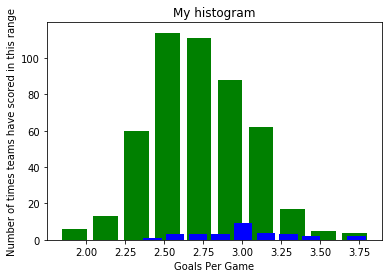

In [168]:
plt.hist(newlist, color = 'green', 
        histtype = 'bar', rwidth = 0.8) 
plt.hist(listofgpg, color = 'blue', histtype= 'bar', rwidth= .8)

# x-axis label 
plt.xlabel('Goals Per Game') 
# frequency label 
plt.ylabel('Number of times teams have scored in this range') 
# plot title 
plt.title('My histogram') 
  
# function to show the plot 
plt.show() 

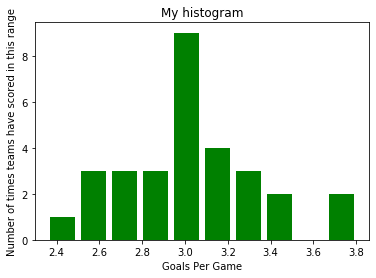

In [29]:
# I want a list of 30 year old NHL players to start with
# players_30 = []
players_3031 = []
series_30 = df.loc[df.Age == 30.0].Player
series_31 = df.loc[df.Age == 31.0].Player

series_30_list = []
series_31_list = []

series_30_list = series_30.tolist()
series_31_list = series_31.tolist()


double = []
# double.append(series_30_list)
double.append(series_31_list)

[double[i] for i in range(len(double)) if i == double.index(double[i])]


# for items30 in series_30.iteritems():
        
        
    

[['Mike Blunden',
  'Jared Boll',
  'Tyler Bozak',
  'Chris Butler',
  'Blake Comeau',
  'David Desharnais',
  'Derek Dorsett',
  'Brandon Dubinsky',
  'Alexander Edler',
  'Alexei Emelin',
  'Carl Gunnarsson',
  'Micheal Haley',
  'Jannik Hansen',
  'Darren Helm',
  'Patric Hornqvist',
  'Jack Johnson',
  'Leo Komarov',
  'David Krejci',
  'Nikolai Kulemin',
  'Trevor Lewis',
  'Andrew MacDonald',
  'Evgeni Malkin',
  'Adam McQuaid',
  'Matt Niskanen',
  "Cal O'Reilly",
  'T.J. Oshie',
  'Roman Polak',
  'Benoit Pouliot',
  'Nate Prosser',
  'Alexander Radulov',
  'Matt Read',
  'Ryan Reaves',
  'Derek Ryan',
  'Andrej Sekera',
  'Marc Staal',
  'Anton Stralman',
  'Kris Versteeg',
  'Blake Wheeler',
  'Keith Yandle',
  'Jay Beagle',
  'Pierre-Edouard Bellemare',
  'Patrice Bergeron',
  'Troy Brouwer',
  'Brent Burns',
  'Dustin Byfuglien',
  'Ryan Callahan',
  'Braydon Coburn',
  'Adam Cracknell',
  'Loui Eriksson',
  'Eric Fehr',
  'Ryan Garbutt',
  'Ryan Getzlaf',
  'Alex Goligoski